In [1]:
import os
import glob
import json
import h5py
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.gridspec as gridspec

from pipeline.python.classifications import utils as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.utils import label_figure, natural_keys

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


In [2]:
%matplotlib notebook

In [3]:
!pip install matplotlib_venn

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:

def do_retino_analysis_on_raw(exp):
    n_frames = exp.data.info['stimulus']['nframes']
    n_files = exp.data.info['ntiffs']
    fr = exp.data.info['stimulus']['frame_rate']
    stimfreq = exp.data.info['stimulus']['stimfreq']

    # label frequency bins
    freqs = np.fft.fftfreq(n_frames, float(1/fr))
    sorted_freq_ixs = np.argsort(freqs)
    freqs=freqs[sorted_freq_ixs]
    print(freqs)

    # exclude DC offset from data
    freqs=freqs[int(np.round(n_frames/2.))+1:]

    # Identify freq idx:
    stim_freq_ix=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
    top_freq_ix=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
    print("Target freq: %.3f Hz" % (freqs[stim_freq_ix]))
    

    trials_by_cond = exp.data.info['trials']
    trial_nums = np.array([v for k,v in trials_by_cond.items()])
    trial_nums = sorted(trial_nums.flatten())

    nframes_total, nrois = exp.data.traces.shape
    magratios=[]
    phases=[]
    conds=[]
    traces={}
    for curr_cond in trials_by_cond.keys():
        avg_traces = []
        for rid in exp.data.traces.columns:
            tracemat = pd.DataFrame(np.reshape(exp.data.traces[rid], (n_frames, n_files), order='F'),\
                                    columns=trial_nums)
            avg = tracemat[trials_by_cond[curr_cond]].mean(axis=1)
            avg_traces.append(avg)
        avg_traces = pd.DataFrame(np.array(avg_traces).T, columns=exp.data.traces.columns)
        traces[curr_cond] = avg_traces

        magratio_array, phase_array = do_fft_analysis(avg_traces, sorted_freq_ixs, stim_freq_ix, n_frames)

        magratios.append(magratio_array)
        phases.append(phase_array)
        conds.append(curr_cond)
        
    magratios = pd.DataFrame(np.array(magratios).T, columns=conds)
    phases = pd.DataFrame(np.array(phases).T, columns=conds)
    
    return magratios, phases, traces

def do_fft_analysis(avg_traces, sorted_freq_ixs, stim_freq_ix, n_frames):
    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_freq_ixs]
    phase_data = phase_data[sorted_freq_ixs]

    # exclude DC offset from data
    mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

    #unpack values from frequency analysis
    mag_array = mag_data[stim_freq_ix, :]
    phase_array = phase_data[stim_freq_ix, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


# Select datasets

In [4]:
rootdir = '/n/coxfs01/2p-data'

animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'


In [5]:
reload(util)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anacond

<module 'pipeline.python.classifications.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.pyc'>

In [5]:
# Create output_dir

output_dir = os.path.join(rootdir, animalid, session, fov, 'summaries')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(output_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/summaries


In [6]:
session_outfile = os.path.join(output_dir, 'sessiondata.pkl')
create_new = False

if os.path.exists(session_outfile) and create_new is False:
    print("creating new session object...")
    with open(session_outfile, 'rb') as f:
        S = pkl.load(f)

else:
    S = util.Session(animalid, session, fov, rootdir=rootdir)
    S.load_data(traceid=traceid, trace_type='corrected')
    
    # Save session data object
    with open(session_outfile, 'wb') as f:
        pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)
    

[JC084] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
Found epi sessions: []
No EPI maps found for session: %s * (trying to use tmp session boundaries file)
('-- getting screen info from:', ['/n/coxfs01/2p-data/JC084/epi_maps/screen_boundaries_tmp.json'])
*********************************
{   'azimuth': 117.5584,
    'bb_left': -58.7792,
    'bb_lower': -33.6615,
    'bb_right': 58.7792,
    'bb_upper': 33.6615,
    'elevation': 67.323,
    'resolution': [1024, 768]}
*********************************
('center 2 Top/Anterior:', 33.6615, 58.7792)
Loading data: traces001 - corrected
[rfs] creating experiment object.
... [combined_rfs_static] getting data path.
... renaming experiment to run name: combined_rfs_static
... loading data array (combined_rfs_static - datasets.npz)
[gratings] creating experiment object.
... [combined_gratings_static] getting data path.
... [mean_Slice01_Channel01_File001_gratings1.png] getting data path.
... no data arrays found 

In [7]:
print(S.experiments.keys())
data_identifier = '|'.join([S.animalid, S.session, S.fov, S.traceid, S.rois])
data_identifier


['rfs', 'gratings', 'blobs', 'retino']


u'JC084|20190522|FOV1_zoom2p0x|traces001|rois001'

In [11]:
# excluded_params = ['position']
# exp = S.experiments['rfs']
# all_params = [c for c in exp.data.sdf.columns if c not in excluded_params]
# tested_params = [c for c in all_params if len(exp.data.sdf[c].unique()) > 1]
# stim_params = dict((str(p), sorted(exp.data.sdf[p].unique())) for p in tested_params)
# stim_params
        

In [8]:
def load_RF_fits(exp):
    assert 'rfs' in S.experiments['rfs'].name, "This is not a RF experiment object! %s" % exp.name
    rf_fits = sorted(glob.glob(os.path.join(exp.source.split('/data_arrays/')[0],
                                     'figures', 'receptive_fields', 'rfs_2dgaus*', '*.pkl')), key=natural_keys)
    if len(rf_fits) > 1:
        for r, ri in enumerate(rf_fits):
            print(r, ri)
        sel = input("-- Select IDX of fits to use: ")
        rfs_fpath = rf_fits[int(sel)]
    else:
        rfs_fpath = rf_fits[0]
    with open(rfs_fpath, 'rb') as f:
        rffits = pkl.load(f)
        
    return rffits

# Get list of "responsive cells" for each experiment

In [74]:
reload(resp)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/test_responsivity.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

<module 'pipeline.python.classifications.test_responsivity' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/test_responsivity.py'>

In [11]:
responsive_test = 'ROC'

mag_ratio_thr = 0.01
rf_fit_thr = 0.5

roi_lists={}
exp_gdfs={}
for exp_name, exp in S.experiments.items():
        
    print("[%s] Loading roi lists..." % exp_name)
    curr_roi_list = []
    
    # Load data:
    exp.data.traces, exp.data.labels = util.check_counts_per_condition(exp.data.traces, exp.data.labels)

    # Load list of "visually responsive" cells
    if exp_name in ['gratings', 'blobs']:
        curr_base_dir = exp.source.split('/data_arrays/')[0]
        try:
            curr_stats_dir = os.path.join(curr_base_dir, 'summary_stats', responsive_test)
            stats_fpath = glob.glob(os.path.join(curr_stats_dir, '*results*.pkl'))
            assert len(stats_fpath) > 0, "No stats results found for: %s" % curr_stats_dir
            with open(stats_fpath[0], 'rb') as f:
                roistats = pkl.load(f)
            curr_roi_list = [r for r, res in roistats.items() if res['pval'] < 0.05]
        except Exception as e:
            print e
            print("-- Unable to load stats: %s [%s]" % (responsive_test, exp_name))
    else:
        if exp_name == 'rfs':
            try:
                rffits = load_RF_fits(S.experiments['rfs'])
                curr_roi_list = [r for r, res in rffits['fits'].items() if res['fit_r']['r2'] >= rf_fit_thr]
            except Exception as e:
                print e
                print("-- No RF fits! [%s]" % exp_name)
        elif 'retino' in exp_name:
            #print("-- Not implemented -- [%s]" % exp_name)
            magratios, phases, traces = do_retino_analysis_on_raw(S.experiments['retino'])
            curr_roi_list = [r for r in magratios.index.tolist() if any(magratios.loc[r] > mag_ratio_thr)]

    roi_lists[exp_name] = curr_roi_list
    
    if 'retino' not in exp_name:
        exp.load(trace_type='dff')
        exp_gdfs[exp_name] = resp.group_roidata_stimresponse(exp.data.traces[curr_roi_list], exp.data.labels, roi_list=curr_roi_list)
    else:
        exp_gdfs[exp_name] = magratios.max(axis=1)
        

[rfs] Loading roi lists...
(0, '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_b78b04_traces001_5c60f6_traces001_7a5ecd_traces001_c80ac8_traces001_656bda_traces001_f17a03/figures/receptive_fields/rfs_2dgaus_responsemin_meanstim0.10_no_trim_/RESULTS_rfs_2dgaus_responsemin_meanstim0.10_no_trim_.pkl')
(1, '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_b78b04_traces001_5c60f6_traces001_7a5ecd_traces001_c80ac8_traces001_656bda_traces001_f17a03/figures/receptive_fields/rfs_2dgaus_responsemin_snr1.50_no_trim_/RESULTS_rfs_2dgaus_responsemin_snr1.50_no_trim_.pkl')
(2, '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_b78b04_traces001_5c60f6_traces001_7a5ecd_traces001_c80ac8_traces001_656bda_traces001_f17a03/figures/receptive_fields/rfs_2dgaus_responsemin_zscore0.00_no_trim_/RESULTS_rfs_2dgaus_responsemin_zscore0.00_no_trim_.pkl')
-- Select IDX of fits to use: 2
... loading data array

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


# Compare rois

In [16]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from matplotlib.patches import Ellipse, Rectangle

from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anacond

In [12]:
for exp_name, rlist in roi_lists.items():
    print('%s: %i rois' % (exp_name, len(rlist)))

rfs: 114 rois
gratings: 124 rois
blobs: 100 rois
retino: 132 rois


In [13]:
import itertools

event_expmts = sorted(['rfs', 'gratings', 'blobs'])

tmp_roi_list = [v for k, v in roi_lists.items()]
all_rois = list(set(itertools.chain(*tmp_roi_list)))

tmp_roi_list = [roi_lists[k] for k in event_expmts]
event_rois = list(set(itertools.chain(*tmp_roi_list)))


In [14]:
#from matplotlib_venn import venn3, venn3_circles
import matplotlib_venn as mpvenn

['blobs', 'gratings', 'rfs']


<IPython.core.display.Javascript object>


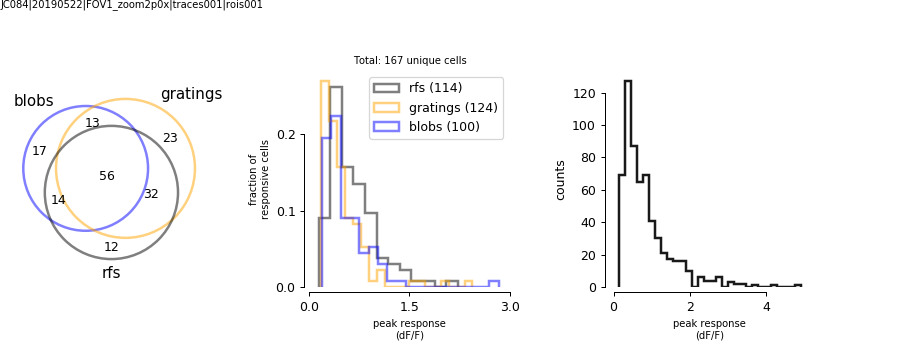

In [17]:
exp_colors= {'rfs': 'black',
            'gratings': 'orange',
             'blobs': 'blue'}
#              'retino': 'gray'}

roi_sets = [set(roi_lists[k]) for k in event_expmts]
roi_set_labels = copy.copy(event_expmts)
print(roi_set_labels)

fig, axes = pl.subplots(1,3, figsize=(10,4))
fig.patch.set_alpha(1)

ax = axes[0]
v = mpvenn.venn3(roi_sets, set_labels=roi_set_labels, ax=ax)
# for pid, ename in zip(['A', 'B', 'C'], roi_set_labels):
#     #v.get_patch_by_id(pid).set_color(exp_colors[ename])
#     v.get_patch_by_id(pid).set_alpha(0)
for pid in v.id2idx.keys():
    #v.get_patch_by_id(pid).set_color(exp_colors[ename])
    v.get_patch_by_id(pid).set_alpha(0)

c=mpvenn.venn3_circles(roi_sets, ax=ax) #set_labels=roi_set_labels, ax=ax)
for ci in range(len(c)):
    c[ci].set_edgecolor(exp_colors[roi_set_labels[ci]])
    c[ci].set_alpha(0.5)
    
#ax.set_title('Event-triggered expmts: %i cells' % len(event_rois), fontsize=8)
#v.get_patch_by_id('rfs').set_color('black')


# Fraction of cells:
ax = axes[1]
for ename in exp_colors.keys():
    if 'retino' in ename:
        peak_values = exp_gdfs[ename].values * 100.
    else:
        peak_values = exp_gdfs[ename].max()['meanstim'].values
    weights = np.ones_like(peak_values) / float(len(event_rois))
    exp_str = '%s (%i)' % (ename, len(peak_values))
    sns.distplot(peak_values, label=exp_str, ax=ax, norm_hist=0, kde=False,
                 rug=False, rug_kws={"alpha": 0.5},
                 hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.5,
                         'weights': weights, 'normed': 0, "color": exp_colors[ename]})
    
ax.set_xlabel('peak response\n(dF/F)', fontsize=8)
ax.set_ylabel('fraction of\nresponsive cells', fontsize=8)
ax.legend()
ax.set_xlim([min([0, ax.get_xlim()[0]]), max([3, ax.get_xlim()[1]])])
ax.xaxis.set_major_locator(MaxNLocator(2))
ax.yaxis.set_major_locator(MaxNLocator(3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine(trim=True, offset=4, ax=ax)
ax.set_title('Total: %i unique cells' % len(event_rois), fontsize=8)

# ALL responses -- counts of cells
ax = axes[2]
all_values = []
for ename, gdf in exp_gdfs.items():
    if 'retino' in ename:
        all_values.extend( gdf.values * 100.)
    else:
        all_values.extend(gdf.max()['meanstim'].values)
#weights = np.ones_like(all_values) / float(len(all_values))
sns.distplot(all_values, ax=ax, norm_hist=0, kde=False,
            rug=False,
            hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.9, # 'weights': weights, 
                        'normed': 0, "color": 'k'}) #[ename]})
sns.despine(trim=True, offset=4, ax=ax)
ax.set_xlabel('peak response\n(dF/F)', fontsize=8)
ax.set_ylabel('counts')

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.01, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(output_dir, "cell_counts_peak_dFF.png"))

# Visualize receptive field coverage

In [18]:
exp = S.experiments['rfs']
rois = roi_lists['rfs']
print(len(rois))

114


In [19]:
S.screen

{'aspect': 0.5726770694395296,
 'azimuth': 'right',
 'bounding_box': [None, None, None, None],
 'elevation': 'top',
 'height': 67.323,
 'linmaxH': 33.661499999999997,
 'linmaxW': 58.779200000000003,
 'linminH': -33.661499999999997,
 'linminW': -58.779200000000003,
 'resolution': [1024, 768],
 'width': 117.5584}

In [20]:
# Get screen bounds: [bottom left upper right]
screen_bounds = [S.screen['linminH'], S.screen['linminW'], S.screen['linmaxH'], S.screen['linmaxW']]
screen_aspect = S.screen['resolution'][0] / S.screen['resolution'][1]

In [21]:
# Get stimulus positions - blobs and gratings only
xpositions=[]; ypositions=[];
for ex in ['blobs', 'gratings']:
    sdf = S.experiments[ex].data.sdf.copy()
    if ex == 'gratings': # deal with FF stimuli
        sdf = sdf[sdf['size']<200]
        sdf.pop('luminance')
    curr_xpos = sdf.dropna()['xpos'].unique()
    assert len(curr_xpos)==1, "[%s] more than 1 xpos found! %s" % (ex, str(curr_xpos))
    curr_ypos = sdf.dropna()['ypos'].unique()
    assert len(curr_ypos)==1, "[%s] more than 1 ypos found! %s" % (ex, str(curr_ypos))
    xpositions.append(curr_xpos[0])
    ypositions.append(curr_ypos[0])

xpos = list(set(xpositions))
assert len(xpos)==1, "blobs and gratings have different XPOS: %s" % str(xpos)
ypos = list(set(ypositions))
assert len(ypos)==1, "blobs and gratings have different YPOS: %s" % str(ypos)
xpos = xpos[0]
ypos = ypos[0]
print("Stimuli presented at coords: (%i, %i)" % (xpos, ypos))


Stimuli presented at coords: (20, -8)


In [22]:
# Get stimulus size(s):
gratings_sz = S.experiments['gratings'].data.sdf['size'].unique().min()
print("Gratings: min apertured size %i" % gratings_sz)

# Get blob size(s):
blobs_sz_min = S.experiments['blobs'].data.sdf.dropna()['size'].unique().min()
blobs_sz_max = S.experiments['blobs'].data.sdf.dropna()['size'].unique().max()
print("Blobs: min/max size = %i/%i" % (blobs_sz_min, blobs_sz_max))

Gratings: min apertured size 20
Blobs: min/max size = 10/50


### Load RF results

In [29]:

def RF_results_to_df(rffits, roi_list=None):
    if roi_list is None:
        roi_list = sorted(rffits.keys())
        
    rf_fits_df = pd.DataFrame({'x0': [rffits['fits'][r]['x0'] for r in roi_list],
                               'y0': [rffits['fits'][r]['y0'] for r in roi_list],
                               'sigma_x': [rffits['fits'][r]['sigma_x'] for r in roi_list],
                               'sigma_y': [rffits['fits'][r]['sigma_y'] for r in roi_list],
                               'theta': [rffits['fits'][r]['theta'] for r in roi_list] },
                              index=roi_list)

    x0, y0, sigma_x, sigma_y = fitrf.convert_fit_to_coords(rf_fits_df, rffits['row_vals'], rffits['col_vals'])
    rf_fits_df['x0'] = x0
    rf_fits_df['y0'] = y0
    rf_fits_df['sigma_x'] = sigma_x
    rf_fits_df['sigma_y'] = sigma_y
    
    return rf_fits_df


def create_ellipse(center, lengths, angle=0):
    """
    create a shapely ellipse. adapted from
    https://gis.stackexchange.com/a/243462
    """
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr

from shapely.geometry import box


def check_path_intersection(ref_patch, sample_patch, all_contained=False):
    ref_path = ref_patch.get_patch_transform().transform_path(ref_patch.get_path())

    verts = sample_patch.get_path().vertices
    trans = sample_patch.get_patch_transform()
    pts = trans.transform(verts)
    
    if all_contained:
        return all(g_path.contains_points(pts))
    else:
        return any(g_path.contains_points(pts))

# # To just check intersection True/False

# ell = Ellipse((x0, y0), abs(sx)*sigma_scale, abs(sy)*sigma_scale, angle=np.rad2deg(th),
#                alpha=0.5, edgecolor='k', lw=0.2, facecolor='none') #theta_f)
# ax.add_patch(ell)

# verts = ell.get_path().vertices
# trans = ell.get_patch_transform()
# pts = trans.transform(verts)

# if check_path_intersection(gratings_patch, ell, all_contained=False):
#     in_gratings.append(roi)
# if check_path_intersection(blobs_min_patch, ell, all_contained=False):
#     in_blobs_min.append(roi)
# if check_path_intersection(blobs_max_patch, ell, all_contained=False):
#     in_blobs_max.append(roi)


In [30]:
# Draw RFs
rffits = load_RF_fits(S.experiments['rfs'])
rf_fits_df = RF_results_to_df(rffits, roi_list=sorted(roi_lists['rfs']))
xres = list(set(np.diff(rffits['col_vals'])))[0]
yres = list(set(np.diff(rffits['row_vals'])))[0]
sigma_scale = 2.36

print("X- and Y-res: (%i, %i)" % (xres, yres))


(0, '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_b78b04_traces001_5c60f6_traces001_7a5ecd_traces001_c80ac8_traces001_656bda_traces001_f17a03/figures/receptive_fields/rfs_2dgaus_responsemin_meanstim0.10_no_trim_/RESULTS_rfs_2dgaus_responsemin_meanstim0.10_no_trim_.pkl')
(1, '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_b78b04_traces001_5c60f6_traces001_7a5ecd_traces001_c80ac8_traces001_656bda_traces001_f17a03/figures/receptive_fields/rfs_2dgaus_responsemin_snr1.50_no_trim_/RESULTS_rfs_2dgaus_responsemin_snr1.50_no_trim_.pkl')
(2, '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_b78b04_traces001_5c60f6_traces001_7a5ecd_traces001_c80ac8_traces001_656bda_traces001_f17a03/figures/receptive_fields/rfs_2dgaus_responsemin_zscore0.00_no_trim_/RESULTS_rfs_2dgaus_responsemin_zscore0.00_no_trim_.pkl')
-- Select IDX of fits to use: 2
X- and Y-res: (5, 5)


#### Load ROI masks

In [23]:
import cv2
import imutils

In [24]:
def load_roi_masks(S, rootdir='/n/coxfs01/2p-data'):
    mask_fpath = glob.glob(os.path.join(rootdir, S.animalid, S.session, 'ROIs', '%s*' % S.rois, 'masks.hdf5'))[0]
    mfile = h5py.File(mask_fpath, 'r')

    # Load and reshape masks
    masks = mfile[mfile.keys()[0]]['masks']['Slice01'][:].T
    print(masks.shape)
    mfile[mfile.keys()[0]].keys()

    zimg = mfile[mfile.keys()[0]]['zproj_img']['Slice01'][:].T
    zimg.shape
    
    return masks, zimg

In [25]:
masks, zimg = load_roi_masks(S)
# Cycle through all ROIs and get their edges
# (note:  tried doing this on sum of all ROIs, but fails if ROIs are overlapping at all)
tmp_roi_contours = []
for ridx in range(masks.shape[-1]):
    im = masks[:,:,ridx]
    im[im>0] = 1
    im[im==0] = np.nan #1
    im = im.astype('uint8')
    edged = cv2.Canny(im, 0, 0.9)
    tmp_cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tmp_cnts = tmp_cnts[0] if imutils.is_cv2() else tmp_cnts[1]
    tmp_roi_contours.append((ridx, tmp_cnts[0]))
print "Created %i contours for rois." % len(tmp_roi_contours)


(512, 512, 260)
Created 260 contours for rois.


In [26]:
# Sort ROIs b y x,y position:

sort_xy =  sorted(tmp_roi_contours, \
                  key=lambda ctr: (cv2.boundingRect(ctr[1])[1] + cv2.boundingRect(ctr[1])[0]) * zimg.shape[1])  

sort_y = sorted(tmp_roi_contours, key=lambda ctr: cv2.boundingRect(ctr[1])[1])
sort_x = sorted(tmp_roi_contours, key=lambda ctr: cv2.boundingRect(ctr[1])[0])

#sorted_roi_contours = [c[1] for c in tmp_sorted_roi_contours]
rois_sort_xaxis = [c[0] for c in sort_x]
rois_sort_yaxis = [c[0] for c in sort_y]

#del tmp_sorted_roi_contours
#del tmp_roi_contours

<IPython.core.display.Javascript object>


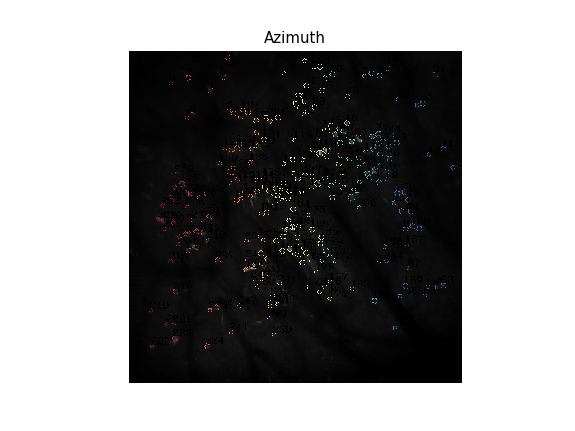

In [579]:
### plot and color-code by position to check sorting:

# fig, ax = pl.subplots()
# util.plot_roi_contours(zimg, roi_contours_ixs, sorted_roi_contours, clip_limit=0.008, label=True, 
#                           draw_box=False, thickness=1, roi_color=(255, 255, 255), single_color=False, ax=ax)

In [27]:
def get_contour_center(cnt):

    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX, cY)

In [28]:
sort_x_centroids = [get_contour_center(cnt[1]) for cnt in sort_x]
sort_y_centroids = [get_contour_center(cnt[1]) for cnt in sort_y]


<IPython.core.display.Javascript object>


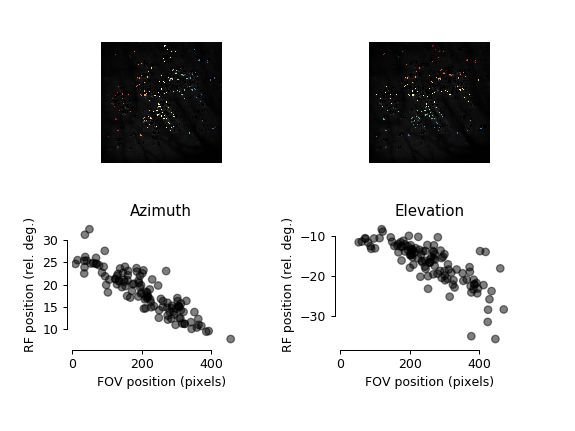

In [32]:
fig, axes = pl.subplots(2,2)

ax = axes[0,0]
util.plot_roi_contours(zimg,[c[0] for c in sort_x], [c[1] for c in sort_x], clip_limit=0.008, label=True, 
                           draw_box=False, thickness=1, roi_color=(255, 255, 255), single_color=False, ax=ax)
ax.axis('off')
                    
ax = axes[0,1]
util.plot_roi_contours(zimg,[c[0] for c in sort_x], [c[1] for c in sort_y], clip_limit=0.008, label=True, 
                           draw_box=False, thickness=1, roi_color=(255, 255, 255), single_color=False, ax=ax)
ax.axis('off')

    
rf_rois = rf_fits_df.index.tolist() 
colors = ['k' for roi in rf_rois]

# Get values for azimuth:
spatial_rank_x = [rois_sort_xaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_x = [sort_x_centroids[s] for s in spatial_rank_x]    # Get corresponding spatial position in FOV
pixel_order_xvals = [p[0] for p in pixel_order_x]
rf_xpos = [rf_fits_df.loc[roi]['x0'] for roi in rf_rois]

# Get values for elevation
spatial_rank_y = [rois_sort_yaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_y = [sort_y_centroids[s] for s in spatial_rank_y]    # Get corresponding spatial position in FOV
pixel_order_yvals = [p[1] for p in pixel_order_y]
rf_ypos = [rf_fits_df.loc[roi]['y0'] for roi in rf_rois]

ax = axes[1,0]
ax.scatter(pixel_order_yvals, rf_xpos, c=colors, alpha=0.5)
ax.set_title('Azimuth')
ax.set_ylabel('RF position (rel. deg.)')
ax.set_xlabel('FOV position (pixels)')
ax.set_xlim([0, 512])
sns.despine(offset=4, trim=True, ax=ax)

ax = axes[1,1]
ax.scatter(pixel_order_xvals, rf_ypos, c=colors, alpha=0.5)
ax.set_title('Elevation')
ax.set_ylabel('RF position (rel. deg.)')
ax.set_xlabel('FOV position (pixels)')
ax.set_xlim([0, 512])
ax.axis('on')
# #ax.set_aspect('auto')
sns.despine(offset=4, trim=True, ax=ax)

pl.subplots_adjust(wspace=0.5, top=0.9, hspace=0.5, bottom=0.2)

#### Calculate RF sizes/overlap with stimuli

<IPython.core.display.Javascript object>


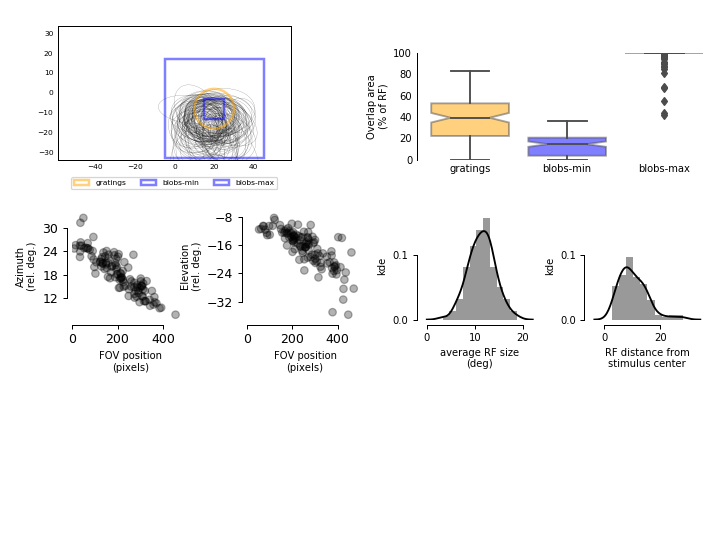

Bbox(x0=0.1, y0=0.7025, x1=0.504545454545, y1=0.9)


In [62]:
gratings_color = 'orange'
blobs_color = 'blue'
colordict = {'gratings': gratings_color,
            'blobs-min': blobs_color,
            'blobs-max': blobs_color}

# PLOT
fig = pl.figure(figsize=(8,6))

# Screen visualization ----------------------------------------------------
ax0 = pl.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=1)
ax0.set_xlim([screen_bounds[1], screen_bounds[3]])
ax0.set_ylim([screen_bounds[0], screen_bounds[2]])
ax0.set_aspect(screen_aspect)
ax0.tick_params(axis='both', which='both', length=0, labelsize=6)

## create GRATINGS patch
s_gratings = create_ellipse((xpos, ypos), (gratings_sz/2., gratings_sz/2.), 0)
v_gratings = np.array(s_gratings.exterior.coords.xy)

## create BLOBS patch(es) - min/max
ry_min = ypos - blobs_sz_min/2.
rx_min = xpos - blobs_sz_min/2.
ry_max = ypos + blobs_sz_min/2.
rx_max = xpos + blobs_sz_min/2.
s_blobs_min = box(rx_min, ry_min, rx_max, ry_max)
v_blobs_min = np.array(s_blobs_min.exterior.coords.xy)

ry_min = ypos - blobs_sz_max/2.
rx_min = xpos - blobs_sz_max/2.
ry_max = ypos + blobs_sz_max/2.
rx_max = xpos + blobs_sz_max/2.
s_blobs_max = box(rx_min, ry_min, rx_max, ry_max)
v_blobs_max = np.array(s_blobs_max.exterior.coords.xy)


# Draw receptive fields, calculate overlap(s):
in_gratings = []
in_blobs_min = []
in_blobs_max = []
rf_dist_from_center = []
rf_avg_size = []
for roi in sorted(roi_lists['rfs']):
    sx, sy, th, x0, y0 = rf_fits_df.loc[roi]
    s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.), np.rad2deg(th))
    v_ell = np.array(s_ell.exterior.coords.xy)
    p_ell = Polygon(v_ell.T, edgecolor='k', alpha=0.5, facecolor='none', lw=0.2)
    ax0.add_patch(p_ell)
    
    ## get intersection and compute areas/ratios:
    intersect_wgratings = s_ell.intersection(s_gratings)
    intersect_wblobs_min = s_ell.intersection(s_blobs_min)
    intersect_wblobs_max = s_ell.intersection(s_blobs_max)
    
    in_gratings.append(intersect_wgratings.area / s_ell.area)
    in_blobs_min.append(intersect_wblobs_min.area / s_ell.area)
    in_blobs_max.append(intersect_wblobs_max.area / s_ell.area)
    
    ## get distance bw RF centers and stimulus location:
    rf_dist_from_center.append(np.sqrt((x0 - xpos)**2 + (y0 - ypos)**2))
    rf_avg_size.append(np.mean([abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.]))
    

# Draw patches:
p_gratings = Polygon(v_gratings.T, edgecolor=gratings_color, alpha=0.5, lw=2, facecolor='none', label='gratings')
ax0.add_patch(p_gratings)
p_blobs_min = Polygon(v_blobs_min.T, edgecolor=blobs_color, alpha=0.5, lw=2, facecolor='none', label='blobs-min')
ax0.add_patch(p_blobs_min)
p_blobs_max = Polygon(v_blobs_max.T, edgecolor=blobs_color, alpha=0.5, lw=2, facecolor='none', label='blobs-max')
ax0.add_patch(p_blobs_max)


# ---- Proportion of RF overlapping with stimulus bounds ----
all_overlap_values = copy.copy(in_gratings)
stimulus_labels = ['gratings' for _ in range(len(in_gratings))]
all_overlap_values.extend(in_blobs_min)
stimulus_labels.extend(['blobs-min' for _ in range(len(in_blobs_min))])
all_overlap_values.extend(in_blobs_max)
stimulus_labels.extend(['blobs-max' for _ in range(len(in_blobs_max))])
stimulus_colors = [colordict[e] for e in stimulus_labels]

overlap_df = pd.DataFrame({'stimulus': stimulus_labels,
                          'overlap': np.array(all_overlap_values)*100.,
                          'color': stimulus_colors})

ax = pl.subplot2grid((3, 4), (0, 2), colspan=2, rowspan=1)
ax = sns.boxplot(x="stimulus", y="overlap", data=overlap_df, ax=ax, 
                 palette=colordict, saturation=1.0, notch=True, boxprops=dict(alpha=.5))
ax.set_xlabel('')
ax.set_ylabel('Overlap area\n(% of RF)', fontsize=8)
ax.set_ylim([0, 100])
ax.tick_params(axis='x', which='both', length=0, labelsize=8)
ax.tick_params(axis='y', which='both', length=0, labelsize=8)

sns.despine(trim=True, offset=4, ax=ax, bottom=True)



# ---- Average RF size -----------------------
ax2a = pl.subplot2grid((3, 4), (1, 2), colspan=1, rowspan=1)
sns.distplot(rf_avg_size, ax=ax2a, color='k')
ax2a.set_xlabel('average RF size\n(deg)', fontsize=8)
ax2a.set_ylabel('kde', fontsize=8)
ax2a.tick_params(axis='both', which='both', length=3, labelsize=8)
ax2a.yaxis.set_major_locator(MaxNLocator(2))
ax2a.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine(trim=True, offset=4, ax=ax2a)

# ---- Distance from stimulus center -----------------------
ax2b = pl.subplot2grid((3, 4), (1, 3), colspan=1, rowspan=1)
sns.distplot(rf_dist_from_center, ax=ax2b, color='k')
ax2b.set_xlabel('RF distance from\nstimulus center', fontsize=8)
ax2b.set_ylabel('kde', fontsize=8)
ax2b.tick_params(axis='both', which='both', length=3, labelsize=8)
ymax = max([ax2a.get_ylim()[-1], ax2b.get_ylim()[-1]])
ax2b.set_ylim([0, ymax])
ax2b.yaxis.set_major_locator(MaxNLocator(2))
ax2b.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine(trim=True, offset=4, ax=ax2b)


# ---- Spatially sorted ROIs vs. RF position -----------------------
rf_rois = rf_fits_df.index.tolist() 

# Get values for azimuth:
spatial_rank_x = [rois_sort_xaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_x = [sort_x_centroids[s] for s in spatial_rank_x]    # Get corresponding spatial position in FOV
pixel_order_xvals = [p[0] for p in pixel_order_x]
rf_xpos = [rf_fits_df.loc[roi]['x0'] for roi in rf_rois]

# Get values for elevation
spatial_rank_y = [rois_sort_yaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_y = [sort_y_centroids[s] for s in spatial_rank_y]    # Get corresponding spatial position in FOV
pixel_order_yvals = [p[1] for p in pixel_order_y]
rf_ypos = [rf_fits_df.loc[roi]['y0'] for roi in rf_rois]

ax3a = pl.subplot2grid((3, 4), (1, 0), colspan=1, rowspan=1)
ax3a.scatter(pixel_order_yvals, rf_xpos, c=colors, alpha=0.3) # FOV y-axis is left-right on brain
#ax3a.set_title('Azimuth', fontsize=8)
ax3a.set_ylabel('Azimuth\n(rel. deg.)', fontsize=8)
ax3a.set_xlabel('FOV position\n(pixels)', fontsize=8)
ax3a.set_xlim([0, 512])
ax3a.yaxis.set_major_locator(MaxNLocator(5))
sns.despine(trim=True, offset=4, ax=ax3a)

ax3b = pl.subplot2grid((3, 4), (1, 1), colspan=1, rowspan=1)
ax3b.scatter(pixel_order_xvals, rf_ypos, c=colors, alpha=0.3) # FOV x-axis is posterior-anterior on brain
ax3b.set_ylabel('Elevation\n(rel. deg.)', fontsize=8)
ax3b.set_xlabel('FOV position\n(pixels)', fontsize=8)
ax3b.set_xlim([0, 512])
#ax.set_aspect('auto')
ax3b.yaxis.set_major_locator(MaxNLocator(5))
sns.despine(trim=True, offset=4, ax=ax3b)


pl.subplots_adjust(left=0.1, top=0.9, right=0.99, wspace=0.5, hspace=0.5)


bbox_s = ax2b.get_position()
bbox_s2 = [bbox_s.x0 - 0.01, bbox_s.y0,  bbox_s.width, bbox_s.height] 
ax2b.set_position(bbox_s2) # set a new position

# Move upper-left plot over to reduce white space
bbox = ax0.get_position()
print(bbox)
bbox2 = [bbox.x0 - 0.04, bbox.y0+0.0,  bbox.width-0.04, bbox.height+0.05] 
ax0.set_position(bbox2) # set a new position
ax0.legend(fontsize=6, ncol=3, loc='lower center', bbox_to_anchor=[0.5, -0.25])




# Stimuli and resize to compare against RFs

In [155]:
def resize_image_to_coords(im, size_deg=30, pix_per_deg=10.01, aspect_scale=1.747):
    print(pix_per_deg)
    ref_dim = max(im.shape)
    resize_factor = ((size_deg*pix_per_deg) / ref_dim ) / pix_per_deg
    scale_factor = resize_factor * aspect_scale
    
    imr = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)
    
    return imr


In [156]:
S.screen

{'aspect': 0.5726770694395296,
 'azimuth': 'right',
 'bounding_box': [None, None, None, None],
 'elevation': 'top',
 'height': 67.323,
 'linmaxH': 33.661499999999997,
 'linmaxW': 58.779200000000003,
 'linminH': -33.661499999999997,
 'linminW': -58.779200000000003,
 'resolution': [1024, 768],
 'width': 117.5584}

In [157]:
# Get image paths:
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'
#object_list = ['D1', 'M14', 'M27', 'M53', 'M66', 'M9', 'M93', 'D2']
object_list = ['D1', 'D2']
image_paths = []
for obj in object_list:
    stimulus_type = 'Blob_%s_Rot_y_fine' % obj
    image_paths.extend(glob.glob(os.path.join(stimulus_dir, stimulus_type, '*_y0.png')))
print("%i images found for %i objects" % (len(image_paths), len(object_list)))

images = {}
for object_name, impath in zip(object_list, image_paths):
    im = cv2.imread(impath)
    images[object_name] = im[:, :, 0]
print("im shape:", images['D1'].shape)


screen_width_deg = 59.7782*2.  #S.screen['linmaxW']*2
screen_height_deg = 33.6615*2. #S.screen['linmaxH']*2

pix_per_degW = S.screen['resolution'][0] / screen_width_deg
pix_per_degH = S.screen['resolution'][1] / screen_height_deg 

print(pix_per_degW, pix_per_degH)
pix_per_deg = np.mean([pix_per_degW, pix_per_degH])
print("avg pix/deg: %.2f" % pix_per_deg)


2 images found for 2 objects
('im shape:', (618, 1080))
(8.564995265832696, 11.407691279354754)
avg pix/deg: 9.99


In [158]:
pix_per_degW

8.564995265832696

<IPython.core.display.Javascript object>


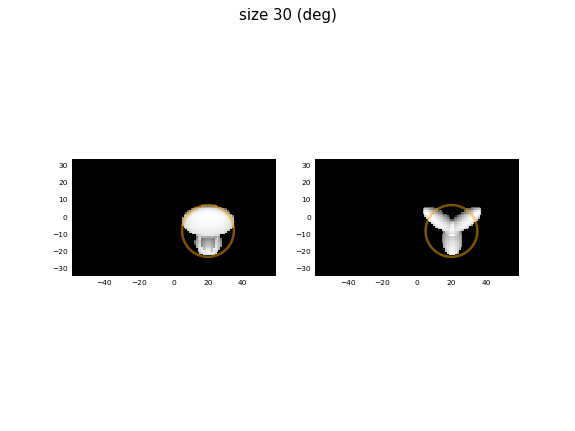

8.56499526583
8.56499526583


In [159]:
size_deg = 30
pix_per_deg = pix_per_degW

# PLOT
fig, axes = pl.subplots(1,2) #pl.figure(figsize=(8,6))
fig.patch.set_alpha(1)
fig.suptitle('size %i (deg)' % size_deg)

# Screen visualization ----------------------------------------------------
#ax0 = pl.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=1)
ax = axes[0]
ax.set_facecolor('k')
ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

imr = resize_image_to_coords(images['D1'], size_deg=size_deg, pix_per_deg=pix_per_deg)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
ax.imshow(imr, cmap='gray', extent=extent)


## create GRATINGS patch
s_gratings = create_ellipse((xpos, ypos), (size_deg/2., size_deg/2.), 0)
v_gratings = np.array(s_gratings.exterior.coords.xy)
# Draw patches:
p_gratings = Polygon(v_gratings.T, edgecolor=gratings_color, alpha=0.5, lw=2, facecolor='none', label='gratings')
ax.add_patch(p_gratings)



#ax0 = pl.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=1)
ax = axes[1]
ax.set_facecolor('k')

ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

imr = resize_image_to_coords(images['D2'], size_deg=size_deg, pix_per_deg=pix_per_deg)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
ax.imshow(imr, cmap='gray', extent=extent)

## create GRATINGS patch
# s_gratings = create_ellipse((xpos, ypos), (gratings_sz/2., gratings_sz/2.), 0)
# v_gratings = np.array(s_gratings.exterior.coords.xy)
# Draw patches:
p_gratings = Polygon(v_gratings.T, edgecolor=gratings_color, alpha=0.5, lw=2, facecolor='none', label='gratings')
ax.add_patch(p_gratings)



# Linear SVM

In [34]:
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [35]:
gdf = exp_gdfs['blobs'] # exp_gdfs use trace_type = 'dff'

In [36]:
sample_data = pd.concat([pd.DataFrame(roidf['meanstim'].values, columns=[roi],
                                          index=roidf['config']) for roi, roidf in gdf], axis=1)
sample_labels = np.array(sample_data.index.tolist())
sample_data = sample_data.reset_index(drop=True)

In [37]:
sample_data.head()

,1,5,9,10,14,17,18,19,21,25,...,233,234,239,241,243,246,248,249,255,258
0,0.085004,0.078445,0.106554,0.097909,0.094718,0.169324,0.117117,0.113041,0.086452,0.079102,...,0.142887,0.212283,0.190839,0.226610,0.161191,0.202333,0.137936,0.134591,0.197417,0.148435
1,0.116828,0.049164,0.130599,0.125293,0.086116,0.081843,0.096113,0.124523,0.088602,0.097290,...,0.195324,0.470202,0.155420,0.288868,0.313260,0.186319,0.145573,0.141516,0.220152,0.148632
2,0.075068,0.074127,0.135879,0.125418,0.069570,0.115841,0.101423,0.107435,0.088562,0.137049,...,0.203921,0.615550,0.197034,0.180002,0.127919,0.251519,0.124421,0.131382,0.300619,0.117500
3,0.092804,0.070447,0.121197,0.108110,0.099519,0.088804,0.073979,0.091653,0.091904,0.188759,...,0.213976,0.577959,0.137583,0.149718,0.191112,0.168339,0.148484,0.145842,0.253615,0.135529
4,0.068792,0.054994,0.101423,0.132127,0.084484,0.083593,0.102552,0.079892,0.070541,0.104962,...,0.153734,0.424986,0.121131,0.151118,0.148967,0.150318,0.094422,0.095364,0.224694,0.152101


In [38]:
sdf = S.experiments['blobs'].data.sdf.copy()
# Exclude non-morph controls for now:
sdf = sdf[sdf['morphlevel']!=-1] # get rid of controls for now
tested_sizes = sorted(sdf ['size'].unique())
tested_morphs = sorted(sdf ['morphlevel'].unique())
print('sizes:', tested_sizes)
print('morphs:', tested_morphs)


('sizes:', [10.0, 20.0, 30.0, 40.0, 50.0])
('morphs:', [0, 14, 27, 40, 53, 66, 79, 92, 106])


In [39]:
#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [0, 106]
restrict_transform = True
constant_transform = 'size'

C = 1e3
m0 = 0
m100 = 106
#fig, ax = pl.subplots()


size_colors = sns.cubehelix_palette(len(tested_sizes))
lw=2


In [40]:
curr_sz = 30
restrict_transform = True

In [41]:
if restrict_transform:
    constant_transform_val = curr_sz
    train_configs = sdf[((sdf[class_name].isin(class_types)) & (sdf[constant_transform]==constant_transform_val))].index.tolist()
else:
    train_configs = sdf[sdf[class_name].isin(class_types)].index.tolist()
print train_configs


# Set train/test set:
train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

X = sample_data.iloc[train_ixs].reset_index(drop=True) #[train_configs]
y = np.array([sdf[class_name][c] for c in sample_labels[train_ixs]])
print X.shape
print y.shape

# # Set validation set:
# untrained_class_types = [c for c in sdf[class_name].unique() if c not in class_types]
# test_configs = sdf[( (sdf[constant_transform]==constant_transform_val) & (sdf[class_name].isin(untrained_class_types)) )].index.tolist()
# test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
# X_test = sample_data.iloc[test_ixs].values
# y_test_labels = sample_labels[test_ixs]



['config008', 'config048']
(60, 100)
(60,)


In [248]:
train, validate, test = np.split(X.sample(frac=1), [int(.6*len(X)), int(.8*len(X))])
print("train:", train.shape)
print("validation:", validate.shape)
print("test:", test.shape)

train_labels = y[np.array(train.index.tolist())]
validate_labels = y[np.array(validate.index.tolist())]
test_labels = y[np.array(test.index.tolist())]


#### Fit & test

scaler = preprocessing.StandardScaler().fit(train)
train_transformed = scaler.transform(train)

# Fit SVM:
trained_svc = LinearSVC(multi_class='ovr', C=C).fit(train_transformed, train_labels)

# Validate:
validate_transformed = scaler.transform(validate)
validate_score = trained_svc.score(validate_transformed, validate_labels)  
validate_predictions = trained_svc.predict(validate_transformed)

# Test:
test_transformed = scaler.transform(test)
test_score = trained_svc.score(test_transformed, test_labels)  
test_predictions = trained_svc.predict(test_transformed)

print("VALIDATE score: %.2f " % (validate_score))
print("TEST score: %.2f " % (test_score))

('train:', (36, 100))
('validation:', (12, 100))
('test:', (12, 100))
VALIDATE score: 0.75 
TEST score: 0.75 


In [249]:
def plot_coefficients(classifier, feature_names, top_features=20, ax=None):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    if ax is None:
        fig, ax = pl.subplots(figsize=(10,4))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    ax.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    ax.set_xticks(np.arange(1, 1 + 2 * top_features))
    ax.set_xticklabels(feature_names[top_coefficients], rotation=60, ha='right')
    
    top_pos_features = feature_names[top_positive_coefficients]
    top_neg_features = feature_names[top_negative_coefficients]
    return top_pos_features, top_neg_features, ax


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=pl.cm.Blues, ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    if ax is None:
        fig, ax = pl.subplots()
        
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [250]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


In [251]:
#confusion_matrix(test_predictions, test_labels, labels=class_types)

# Plot normalized confusion matrix
# plot_confusion_matrix(test_labels, test_predictions, classes=class_types, normalize=True,
#                       title='Normalized confusion matrix')


### Plot top features and RFs overlaid w/ stimulus

<IPython.core.display.Javascript object>


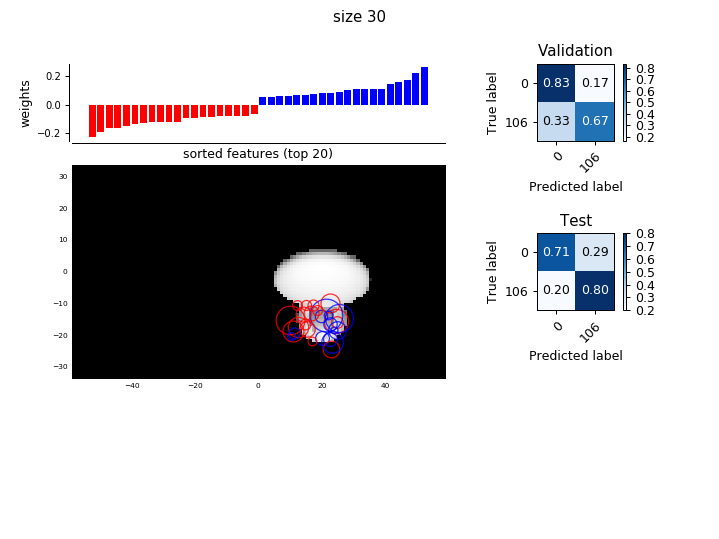

There are 28 cells with RF fits in the top 20 features
('top pos:', [25, 26, 31, 61, 67, 77, 91, 93, 118, 134, 168, 243])
('top neg:', [17, 19, 69, 119, 125, 155, 160, 163, 165, 175, 184, 191, 212, 230, 255, 258])
8.56499526583
Normalized confusion matrix
[[ 0.83333333  0.16666667]
 [ 0.33333333  0.66666667]]
Normalized confusion matrix
[[ 0.71428571  0.28571429]
 [ 0.2         0.8       ]]


Text(0.5,0.98,u'size 30')

In [252]:
fig = pl.figure(figsize=(8, 6)) # = pl.subplots(2,1)

ax0 = pl.subplot2grid((5, 3), (0, 0), colspan=2, rowspan=1)
n_top_features=20
top_pos, top_neg, ax = plot_coefficients(trained_svc, train.columns.tolist(), top_features=n_top_features, ax=ax0)
sns.despine(offset=2, ax=ax0)
ax0.set_xlabel('sorted features (top %i)' % n_top_features)
ax0.set_ylabel('weights')
ax0.set_xticks([])
ax0.tick_params(axis='both', which='both', length=3, labelsize=8, rotation=0)


# Get receptive fields:
matched_rois = [r for r in rf_fits_df.index.tolist() if r in top_pos or r in top_neg]
print("There are %i cells with RF fits in the top 20 features" % len(matched_rois))

print("top pos:", [r for r in matched_rois if r in top_pos])
print("top neg:", [r for r in matched_rois if r in top_neg])

ax = pl.subplot2grid((5, 3), (1, 0), colspan=2, rowspan=3)
ax.set_facecolor('k')

# Screen visualization ----------------------------------------------------
ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

imr = resize_image_to_coords(images['D1'], size_deg=curr_sz, pix_per_deg=pix_per_degW)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
ax.imshow(imr, cmap='gray', extent=extent)

## plot RFs -----------------------------------------------
for roi in matched_rois:
    if roi in top_pos:
        roi_color = 'blue'
    elif roi in top_neg:
        roi_color = 'red'  
        
    sx, sy, th, x0, y0 = rf_fits_df.loc[roi]
    feature_weight = trained_svc.coef_.ravel()[train.columns.tolist().index(roi)]
    ax.plot(x0, y0, color=roi_color, marker='o', markersize=np.abs(feature_weight)*100, \
            markerfacecolor='none', markeredgecolor=roi_color, alpha=0.8)
    

ax1 = pl.subplot2grid((5, 3), (0, 2), colspan=1, rowspan=1)
plot_confusion_matrix(validate_labels, validate_predictions, classes=class_types, normalize=True,
                      title='Validation', ax=ax1)

ax2 = pl.subplot2grid((5, 3), (2, 2), colspan=1, rowspan=1)
plot_confusion_matrix(test_labels, test_predictions, classes=class_types, normalize=True,
                      title='Test', ax=ax2)

    
pl.subplots_adjust(hspace=0.1, left=0.1)
fig.suptitle('size %i' % curr_sz)

In [56]:
top_pos

array([  1, 168, 214,  84, 100,  77, 212,  67, 146, 151, 106, 150, 190,
       243,  93, 148,  14,  26,  91, 118])

<IPython.core.display.Javascript object>


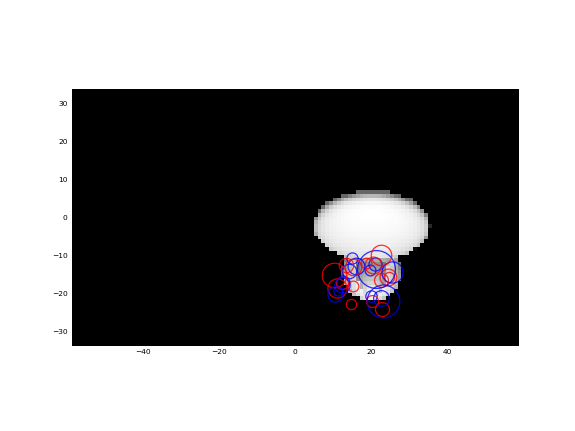

8.56499526583


In [160]:
fig, ax = pl.subplots()

ax.set_facecolor('k')

# Screen visualization ----------------------------------------------------
ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

imr = resize_image_to_coords(images['D1'], size_deg=curr_sz, pix_per_deg=pix_per_degW)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
ax.imshow(imr, cmap='gray', extent=extent)

## plot RFs -----------------------------------------------
for roi in matched_rois:
    if roi in top_pos:
        roi_color = 'blue'
    elif roi in top_neg:
        roi_color = 'red'  
        
    sx, sy, th, x0, y0 = rf_fits_df.loc[roi]
    feature_weight = trained_svc.coef_.ravel()[train.columns.tolist().index(roi)]
    ax.plot(x0, y0, color=roi_color, marker='o', markersize=np.abs(feature_weight)*100, \
            markerfacecolor='none', markeredgecolor=roi_color, alpha=0.8)
    
## create GRATINGS patch
# s_gratings = create_ellipse((xpos, ypos), (size_deg/2., size_deg/2.), 0)
# v_gratings = np.array(s_gratings.exterior.coords.xy)
# # Draw patches:
# p_gratings = Polygon(v_gratings.T, edgecolor=gratings_color, alpha=0.5, lw=2, facecolor='none', label='gratings')
# ax.add_patch(p_gratings)

In [102]:
618./pix_per_deg, 1080./pix_per_deg

(61.436738204120722, 107.36517356059933)

# Retino data

In [79]:
magratios, phases, traces = do_retino_analysis_on_raw(S.experiments['retino'])

[-22.31640161 -22.29640484 -22.27640806 ...,  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz


#### Look at best cell

In [77]:
magratios[magratios['right'] == magratios.max()['right']]

,top,right,left,bottom
67,0.030328,0.049055,0.035195,0.045492


<IPython.core.display.Javascript object>


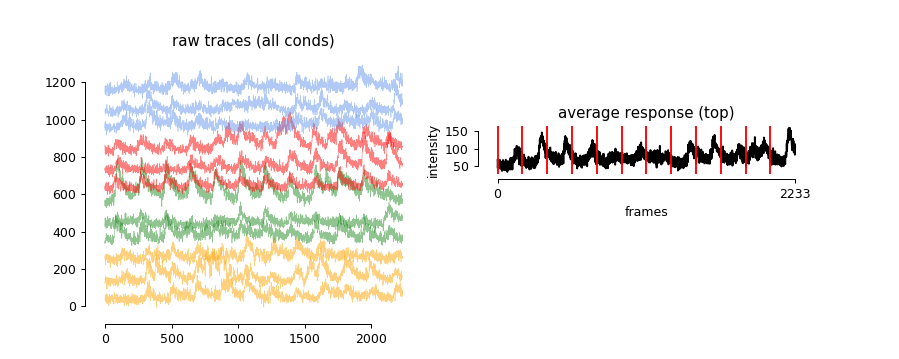

(2233,)


In [107]:
roi = 67

curr_cond = 'right' #max_mod_condn
n_frames = S.experiments['retino'].data.info['stimulus']['nframes']
n_files = S.experiments['retino'].data.info['ntiffs']
cycle_starts = S.experiments['retino'].data.info['stimulus']['cycle_start_ixs']

fig = pl.figure(figsize=(10,4))
gspec = gridspec.GridSpec(ncols=2, nrows=4, height_ratios=[1, 1, 1, 1])

# ax1 = fig.add_subplot(gspec[0, 0])
# ax1.imshow(np.reshape(S.experiments['retino'].data.traces[roi], cnm.dims, order='F'))
# ax1.set_title('rid %i' % rid)
# ax1.axis('off')

offset=100
trials_by_cond = S.experiments['retino'].data.info['trials']
colordict = {'right': 'forestgreen', 'left': 'orange',
            'top': 'cornflowerblue', 'bottom': 'red'}
ax2 = fig.add_subplot(gspec[:, 0])
tmat = np.reshape(S.experiments['retino'].data.traces[roi], (n_frames, n_files), order='F')
grouped_trials = copy.copy(trials_by_cond['left'])
for cond in ['right', 'bottom', 'top']:
    grouped_trials.extend(trials_by_cond[cond])
for ti, tnum in enumerate(grouped_trials): #range(tmat.shape[1]):
    curr_cond = [cond for cond, tlist in trials_by_cond.items() if tnum in tlist][0]
    curr_color = colordict[curr_cond]
    ax2.plot(tmat[:, tnum-1] + ti*offset, color=curr_color, alpha=0.5, lw=0.5)
ax2.set_title('raw traces (all conds)')

ax3 = fig.add_subplot(gspec[1, 1])
avg = traces[curr_cond][roi]
print(avg.shape)
ax3.plot(avg, 'k')
ax3.set_xticks([0, n_frames])
for cyc in cycle_starts:
    ax3.axvline(x=cyc, color='r')
ax3.set_title('average response (%s)' % curr_cond)
ax3.set_ylabel('intensity')
ax3.set_xlabel('frames')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(top=0.85, left=0.1, hspace=0.5)
#label_figure(fig, data_identifier)

In [113]:
magratios.loc[67]

top       0.030328
right     0.049055
left      0.035195
bottom    0.045492
Name: 67, dtype: float64

In [114]:
magratio_thr = 0.01
retino_rois = [r for r in magratios.index.tolist() if any(magratios.loc[r] > magratio_thr)]
print(len(retino_rois))
                                                          

132


In [110]:
magratios.loc[roi]

top       0.030328
right     0.049055
left      0.035195
bottom    0.045492
Name: 67, dtype: float64